In [1]:
# Install required packages

%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-swarm 

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.5 MB 3.8 MB/s eta 0:00:01
   ----------------------------- ---------- 1.8/2.5 MB 5.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 4.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 5.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/12.6 MB 7.2 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/12.6 MB 8.4 MB/s eta 0:00:02
   ---------------- ----------------------- 5.2/12.6 MB 8.9 MB/s eta 0:00:01
   ------------------------ --------------- 7.6/12.6 MB 9.2 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.6 MB 9.5 MB/s eta 0:00:01
   -------------------------------------- - 12.1/12.6 MB 9.6 MB/s eta 0:00:01
   ----------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("MODEL")                  # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")


In [3]:
# Swarm Example:
# In this setup, each agent can communicate with every other agent (many-to-many connections).
# Agents can decide which agent to call next during their reasoning process.

import os
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm

# Load the model name from environment variables
default_model = os.environ["MODEL"]

# Initialize the LLM (Large Language Model) interface
llm = ChatOpenAI(model=default_model)

# ---- Tool Definitions ----

# Define a simple 'add' function tool that adds two numbers
def add(a: int, b: int) -> int:
    """Add two numbers"""
    return a + b

# ---- Agent Definitions ----

# Create the 'Alice' agent:
# - Expert in addition problems.
# - Can either solve the query directly or hand it off to Bob if necessary.
alice = create_react_agent(
    llm,
    tools=[
        add, 
        create_handoff_tool(agent_name="Bob")  # Tool to transfer the conversation to Bob
    ],
    prompt=(
        "You are an agent - your name is Alice. You are an addition expert and handle simple math queries that involve addition."
        "If you are not sure about how to add numbers, use your tools to do so: do NOT guess or make up an answer."
        "Please keep going until the user’s query is completely resolved before ending your turn and yielding back to the user."
        "Only terminate your turn when you are sure that the problem is solved or you have transferred the query to other agents."
    ),
    name="Alice",
)

# Create the 'Bob' agent:
# - Bob speaks like a pirate but does not handle math problems himself.
# - He can only transfer the query back to Alice if needed.
bob = create_react_agent(
    llm,
    tools=[
        create_handoff_tool(agent_name="Alice", description="Transfer to Alice, she can help with math")
    ],
    prompt=(
        "You are an agent - your name is Bob, you speak like a pirate and that is the only skill you have."
        "Do NOT guess or make up an answer. Please keep going until the user´s query is completely resolved, before ending your turn and yielding back to the user."
        "Only terminate your turn when you are sure that the problem is solved or you have transferred the query to other agents."        
    ),
    name="Bob",
)



In [4]:
# ---- Swarm and Workflow Definition ----

# In-memory checkpointing to save intermediate agent states during the conversation
checkpointer = InMemorySaver()

# Create a swarm (multi-agent environment) where agents can call each other
workflow = create_swarm(
    [alice, bob],  # List of agents
    default_active_agent="Alice"  # Alice starts the conversation
)

# Compile the swarm workflow into an executable app
app = workflow.compile(checkpointer=checkpointer)

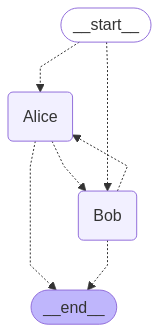

In [5]:
# ---- Visualize ----

# Display the compiled agent graph using Mermaid (rendered as PNG)
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))


In [6]:
# ---- Stream User Interactions ----

# Configuration for conversation (e.g., thread ID to track session)
config = {"configurable": {"thread_id": "1"}}

# --- Turn 1: User asks to speak to Bob ---

for step in app.stream(
    input={"messages": [{"role": "user", "content": "I'd like to speak to Bob"}]},
    config=config,
    subgraphs=True,
    debug=True
):
    print(step)
    print("============================")

# --- Turn 2: User asks a math question ---

for step in app.stream(
    input={"messages": [{"role": "user", "content": "What's 21 + 9 + 5?"}]},
    config=config,
    subgraphs=True,
    debug=True
):
    print(step)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [{'content': "I'd like to speak to Bob", 'role': 'user'}]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [{'content': "I'd like to speak to Bob", 'role': 'user'}]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content="I'd like to speak to Bob", additional_kwargs={}, response_metadata={}, id='ff049511-e647-426e-a543-8a42bc551bdb')]}
[1:tasks] Starting 1 task for step 1:
- Alice -> {'messages': [HumanMessage(content="I'd like to speak to Bob", additional_kwargs={}, response_metadata={}, id='ff049511-e647-426e-a543-8a42bc551bdb')]}
(('Alice:c1fec153-c32b-6d89-7d2f-f9dc2d541814',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_FXvbO2j3XaqmGJAgB0h621Kk', 'function': {'arguments': '{}', 'name': 'transfer_to_bob'}, 'type': 'function'}], 'refusal': None}, response_metadata={'to